In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.12.0


In [14]:
batch_size = 128
image_size = 224
test_size = 0.2

# Load Data and division of Data
Total validation images = 16

Total training images = 5216

There is lot of training images compare to validation images and division between these two dataset not in 80:20 ratio.

In below cell, divsion of 80:20 performed after merging all the validation and training images in a list of files.

In [15]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

In [16]:
train = get_training_data('Dataset/train')
test = get_training_data('Dataset/test')
val = get_training_data('Dataset/val')

In [17]:
print(f'Before division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}\n')


combined_array = np.concatenate((train, val))
np.random.shuffle(combined_array)
print(f'Total number of images : training_images + validation_images = {len(combined_array)}\n')

train = combined_array[:int(len(combined_array) * 0.8)]
val = combined_array[int(len(combined_array) * 0.8):]
print(f'After division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}')

Before division of 80:20
Total number of training images = 5216
Total number of validation images = 16

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


# Data Visualization and Pre-processing

<AxesSubplot:ylabel='count'>

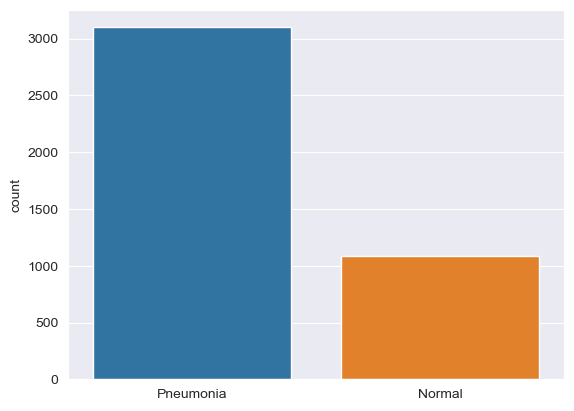

In [18]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

In [19]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [20]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [22]:
# resize data for deep learning 
x_train = x_train.reshape(-1, image_size, image_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, image_size, image_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, image_size, image_size, 3)
y_test = np.array(y_test)

# Data Augmentation

In [23]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    )


datagen.fit(x_train)

In [24]:
x_train.shape

(4185, 224, 224, 3)

# VGG Net Model (After Tuning)

All the below parameters are found by experimenting many times while fine-tuning the model. i.e for Dense layers, it was trained with different no. of neurons (4096, 1024, 512) but the best result found by taking 512 neurons for Dense layers and using Dropout (0.2 and 0.5 while fine-tuning) 0.2 gives us best result.

In [25]:
base_model1 = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),include_top=False, weights='imagenet')
base_model1.trainable = False


model1 = tf.keras.Sequential([
        base_model1,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
        ])

model1.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

Below code block shows, number of layers for base model (vgg) which is 19 and out of 19 I choose to freeze all 19 layers while training it means we will not be training those 19 freezed layers.

In [26]:
print(len( base_model1.layers))

19


In [37]:
checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint("model1_vgg.h5",
                                                    save_best_only=True)

early_stopping_cb1 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=5, mode = 'min',restore_best_weights=True)

### Train the model

In [38]:
history = model1.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    steps_per_epoch = 10,
                    epochs = 10, 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [checkpoint_cb1,early_stopping_cb1])

Epoch 1/10
10/10 [==============================] - 143s 15s/step - loss: 0.1956 - accuracy: 0.9281 - val_loss: 0.1760 - val_accuracy: 0.9370
Epoch 2/10
10/10 [==============================] - 143s 15s/step - loss: 0.2115 - accuracy: 0.9281 - val_loss: 0.1394 - val_accuracy: 0.9484
Epoch 3/10
10/10 [==============================] - 145s 16s/step - loss: 0.1364 - accuracy: 0.9438 - val_loss: 0.1527 - val_accuracy: 0.9427
Epoch 4/10
10/10 [==============================] - 145s 16s/step - loss: 0.1674 - accuracy: 0.9281 - val_loss: 0.1276 - val_accuracy: 0.9522
Epoch 5/10
10/10 [==============================] - 145s 16s/step - loss: 0.1263 - accuracy: 0.9531 - val_loss: 0.1756 - val_accuracy: 0.9322
Epoch 6/10
10/10 [==============================] - 146s 16s/step - loss: 0.1762 - accuracy: 0.9344 - val_loss: 0.1370 - val_accuracy: 0.9408
Epoch 7/10
10/10 [==============================] - 148s 16s/step - loss: 0.2129 - accuracy: 0.9344 - val_loss: 0.1173 - val_accuracy: 0.9570
Epoch 

Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

In [39]:
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 64s 3s/step - loss: 0.2299 - accuracy: 0.9231
Loss of the model is -  0.22985820472240448
20/20 [==============================] - 64s 3s/step - loss: 0.2299 - accuracy: 0.9231
Accuracy of the model is -  92.30769276618958 %


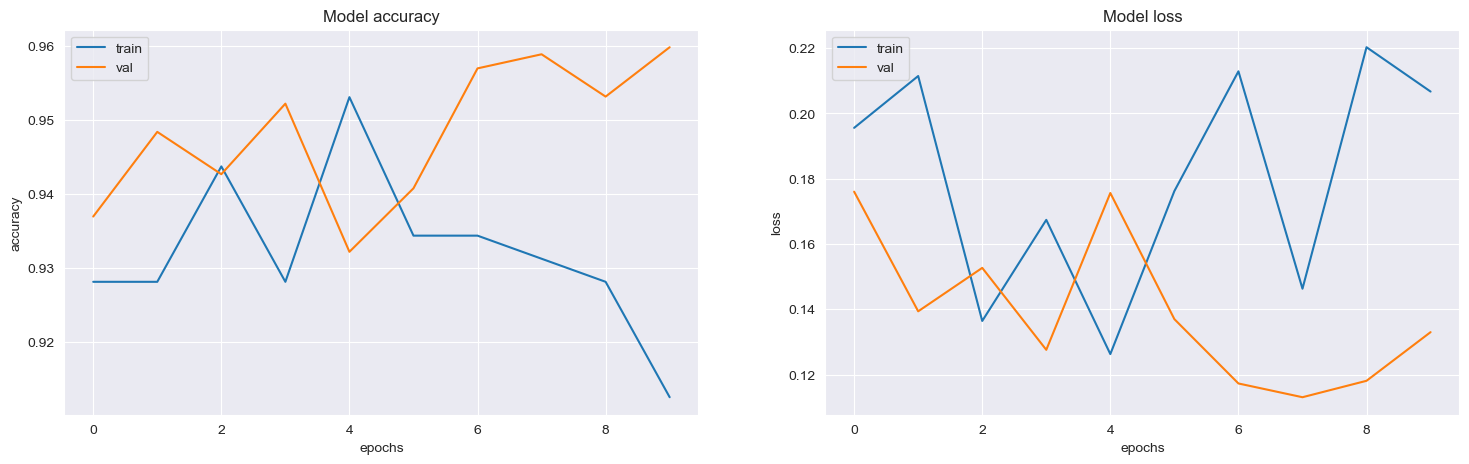

In [40]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [43]:
predictions = (model1.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:-1]

20/20 [==============================] - 63s 3s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.97      0.94       390
   Normal (Class 1)       0.94      0.85      0.89       234

           accuracy                           0.92       624
          macro avg       0.93      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



In [46]:
cm = confusion_matrix(y_test,predictions)
cm

array([[378,  12],
       [ 36, 198]], dtype=int64)

In [47]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

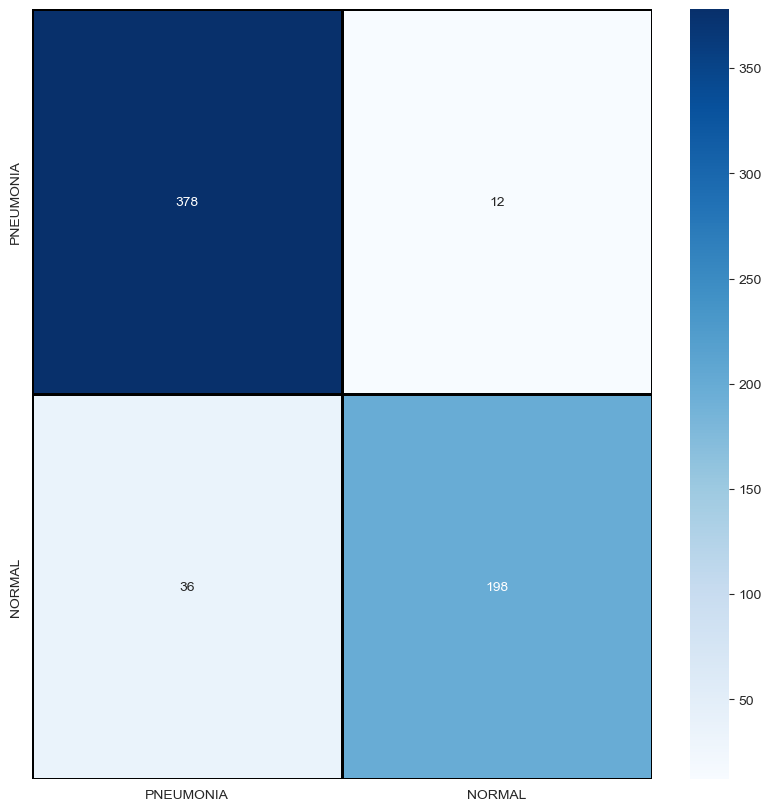

In [48]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [50]:
history = model1.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    steps_per_epoch = 10,
                    epochs = 5, 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [checkpoint_cb1,early_stopping_cb1])

Epoch 1/5
10/10 [==============================] - 147s 16s/step - loss: 0.1814 - accuracy: 0.9250 - val_loss: 0.1359 - val_accuracy: 0.9465
Epoch 2/5
10/10 [==============================] - 154s 17s/step - loss: 0.1465 - accuracy: 0.9500 - val_loss: 0.1735 - val_accuracy: 0.9236
Epoch 3/5
10/10 [==============================] - 145s 16s/step - loss: 0.1952 - accuracy: 0.9187 - val_loss: 0.1674 - val_accuracy: 0.9341
Epoch 4/5
10/10 [==============================] - 150s 16s/step - loss: 0.2169 - accuracy: 0.9312 - val_loss: 0.1419 - val_accuracy: 0.9408
Epoch 5/5
10/10 [==============================] - 147s 16s/step - loss: 0.1877 - accuracy: 0.9062 - val_loss: 0.1183 - val_accuracy: 0.9599


Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

In [51]:
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 67s 3s/step - loss: 0.2261 - accuracy: 0.9231
Loss of the model is -  0.226120263338089
20/20 [==============================] - 66s 3s/step - loss: 0.2261 - accuracy: 0.9231
Accuracy of the model is -  92.30769276618958 %


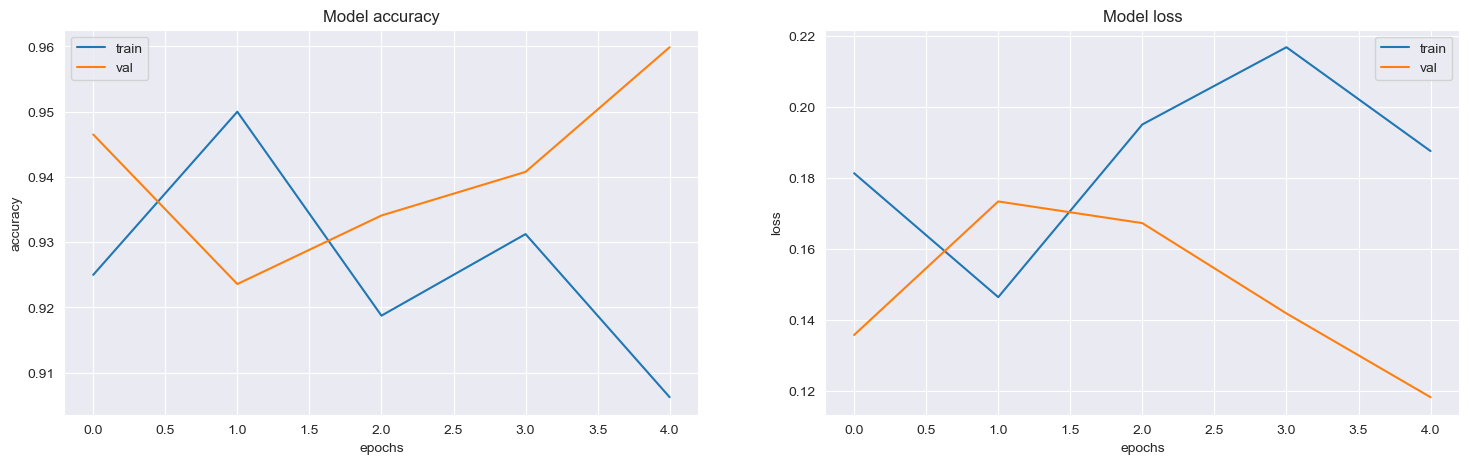

In [52]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [53]:
predictions = (model1.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 66s 3s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.97      0.94       390
   Normal (Class 1)       0.95      0.84      0.89       234

           accuracy                           0.92       624
          macro avg       0.93      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



In [55]:
cm = confusion_matrix(y_test,predictions)
cm

array([[379,  11],
       [ 37, 197]], dtype=int64)

In [56]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

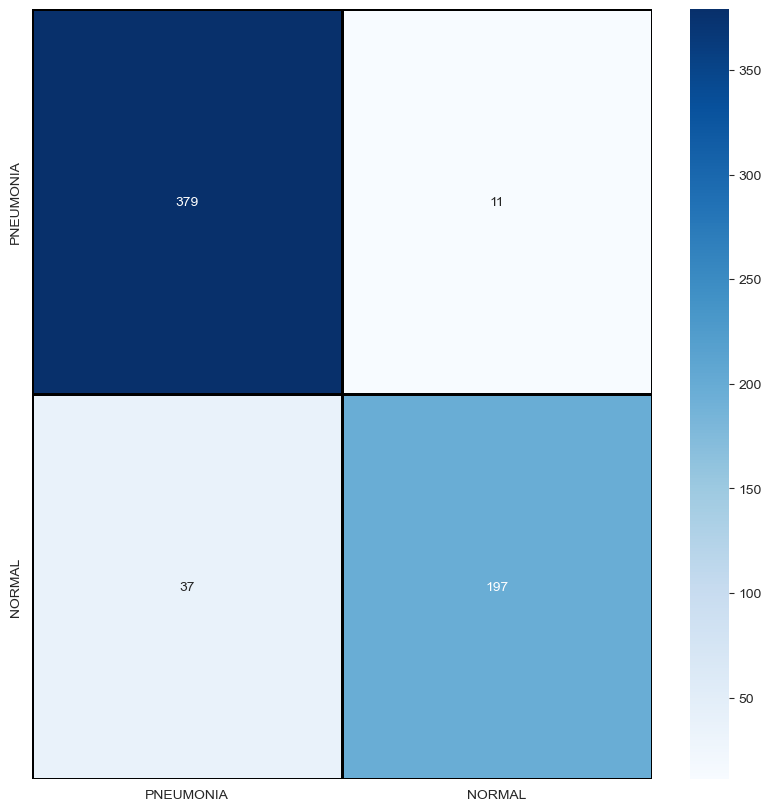

In [57]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)